In [1]:
from datetime import timedelta, datetime as dt
from itertools import combinations
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests, adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.signal import correlate, correlation_lags

%matplotlib inline

In [2]:
df = pd.read_csv('bitcoin_final.csv', index_col='date', parse_dates=True)
df.describe()

,close,volume,nbdi
count,2923.000000,2923.000000,2923.000000
mean,16897.774133,14868.521186,115.716469
std,16324.767541,11898.323580,4.258462
min,357.530000,683.798071,106.487700
25%,4102.455000,6947.576814,112.713900
50%,9676.630000,11794.060489,115.186500
75%,27379.820000,18922.021720,118.427300
max,67554.840000,130316.646844,128.454400


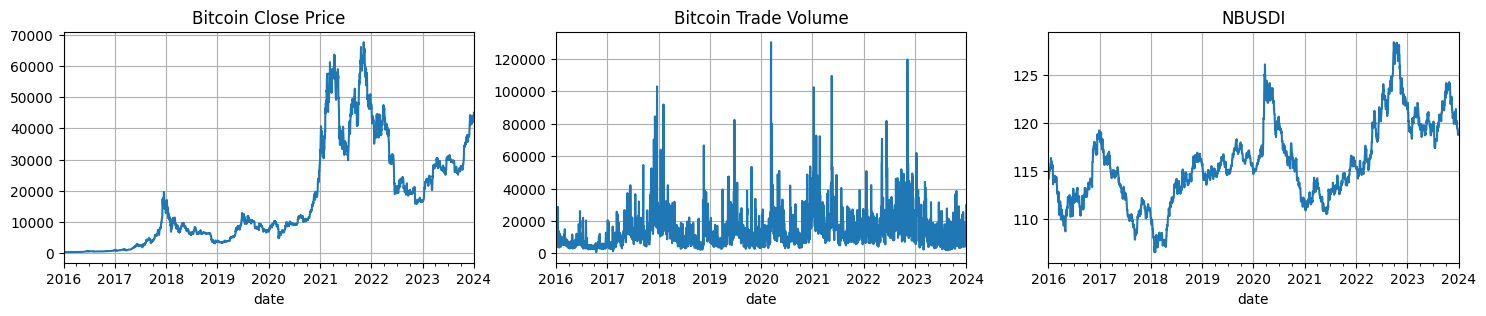

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3))

df.close.plot(ax=ax[0], grid=True)
ax[0].title.set_text('Bitcoin Close Price')
df.volume.plot(ax=ax[1], grid=True)
ax[1].title.set_text('Bitcoin Trade Volume')
df.nbdi.plot(ax=ax[2], grid=True)
ax[2].title.set_text('NBUSDI')
plt.show()

### IMPRESSIONS

Bitcoin Closing Price
- Appears non-stationary, no discernable seasonality or cyclicality, assumed stochastic trend.
- Notable features include peaks in early and late 2021

Bitcoin Trade Volume
- Appears non-stationary with potential for seasonality and cyclicality, assumed weak upward trend.
- Notable features include short periods of volatility that create outliers

Nominal Broad Dollar Index
- Appears to be non-stationary with no discernable seasonality or cyclicality, assumed stochastic trend
- Notable features include rising peaks in 2017, 2020, and 2022

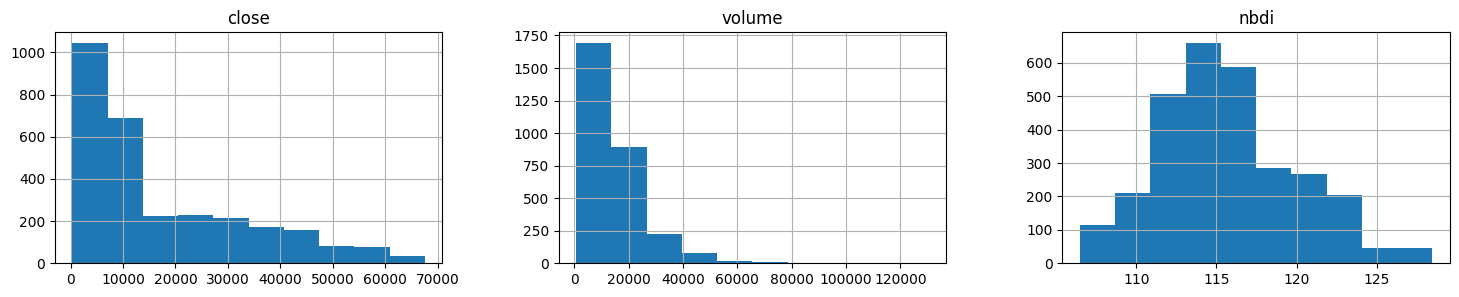

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3))
df.hist('close', ax=ax[0])
df.hist('volume', ax=ax[1])
df.hist('nbdi', ax=ax[2])
plt.show()

### Impressions

- Bitcoin Closing Price: Right-tailed distribution with pronounced tail, mean greater than median, majority of close prices are less than 10,000
- Bitcoin Trade Volume: Right-tailed distribution with short tail, mean greater than median, majority of values are less than 25,000
- Nominal Broad Dollar Index: nearly normal distribution with equivalent mean and median, majority of values revolve around the mean of 115

## Plot and Compare Variables

In [3]:
# use close price differenced value for ACF/PACF later
df['close_diff'] = df.close.diff()

close_scaler = MinMaxScaler().fit(df.close.values.reshape(-1, 1))
nbdi_scaler = MinMaxScaler().fit(df.nbdi.values.reshape(-1, 1))
volume_scaler = MinMaxScaler().fit(df.volume.values.reshape(-1, 1))

# minmax scale our variables for ease of interpretability
close_mmscaled = close_scaler.transform(df.close.values.reshape(-1, 1))
nbdi_mmscaled = nbdi_scaler.transform(df.nbdi.values.reshape(-1, 1).reshape(-1, 1))
volume_mmscaled = volume_scaler.transform(df.volume.values.reshape(-1, 1).reshape(-1, 1))

# break time series into segments
pre_pandemic = df.loc[:'2020-03-10', :]
post_pandemic = df.loc['2020-03-11':, :]

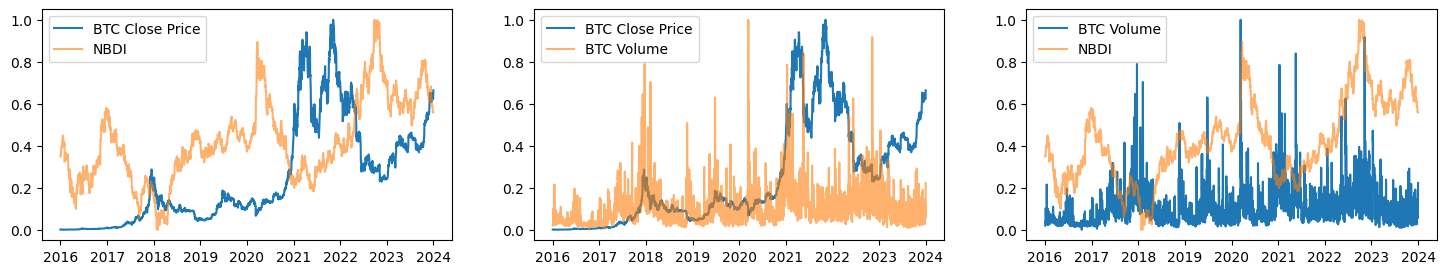

In [8]:
close_mmscaled = MinMaxScaler().fit_transform(df.close.values.reshape(-1, 1))
nbdi_mmscaled = MinMaxScaler().fit_transform(df.nbdi.values.reshape(-1, 1))
volume_mmscaled = MinMaxScaler().fit_transform(df.volume.values.reshape(-1, 1))

fig, ax = plt.subplots(1, 3, figsize=(18, 3))
ax[0].plot(df.index, close_mmscaled, label="BTC Close Price")
ax[0].plot(df.index, nbdi_mmscaled, label="NBDI", alpha=0.6)
ax[0].legend()

ax[1].plot(df.index, close_mmscaled, label="BTC Close Price")
ax[1].plot(df.index, volume_mmscaled, label="BTC Volume", alpha=0.6)
ax[1].legend()

ax[2].plot(df.index, volume_mmscaled, label="BTC Volume")
ax[2].plot(df.index, nbdi_mmscaled, label="NBDI", alpha=0.6)
ax[2].legend()

plt.show()

### Findings

1) Possible lag effect between NBDI and close price.
2) No apparent relationship between close price and volume.
3) No apparent relationship between volume and NBDI.

Text(0.5, 0.98, 'Post-Pandemic')

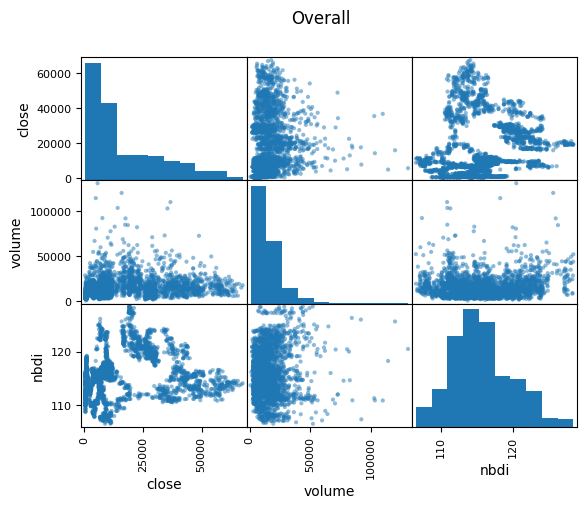

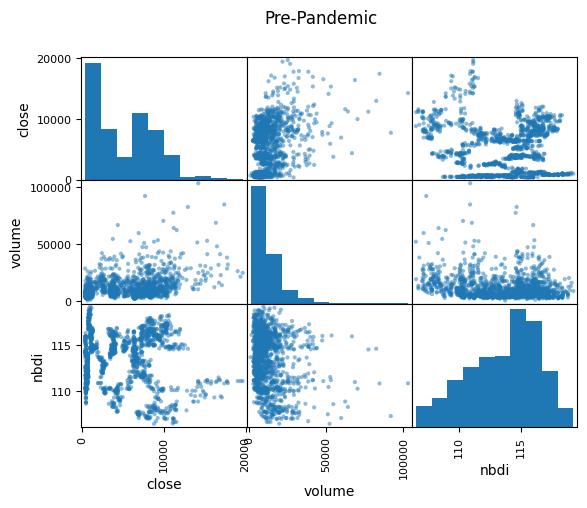

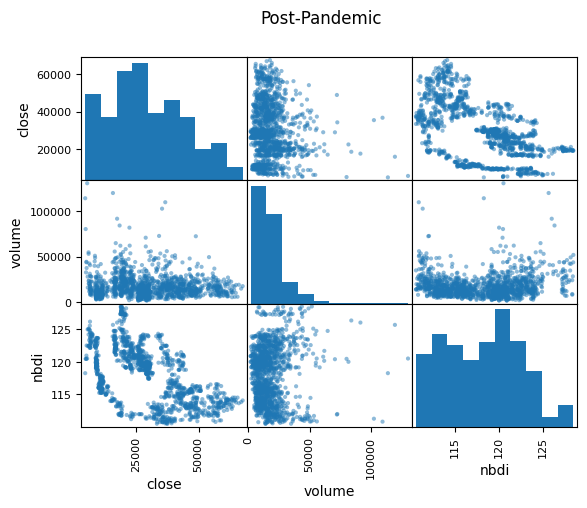

In [47]:
pd.plotting.scatter_matrix(df)
plt.suptitle('Overall')
pd.plotting.scatter_matrix(pre_pandemic)
plt.suptitle('Pre-Pandemic')
pd.plotting.scatter_matrix(post_pandemic)
plt.suptitle('Post-Pandemic')

### Findings

- No linear or near-linear relationships observed.
- Noticeable change in clustering of price/nbdi pair between pre-pandemic and post-pandemic segments.
- Price and volume have a right-tailed distribution of values.  NBDI also right-tailed, but more normal than other variables.

<hr>

## Plot and Compare Moving Averages

/tmp/ipykernel_214245/2052394207.py:5: UserWarning: The figure layout has changed to tight
  fig.tight_layout(pad=2)


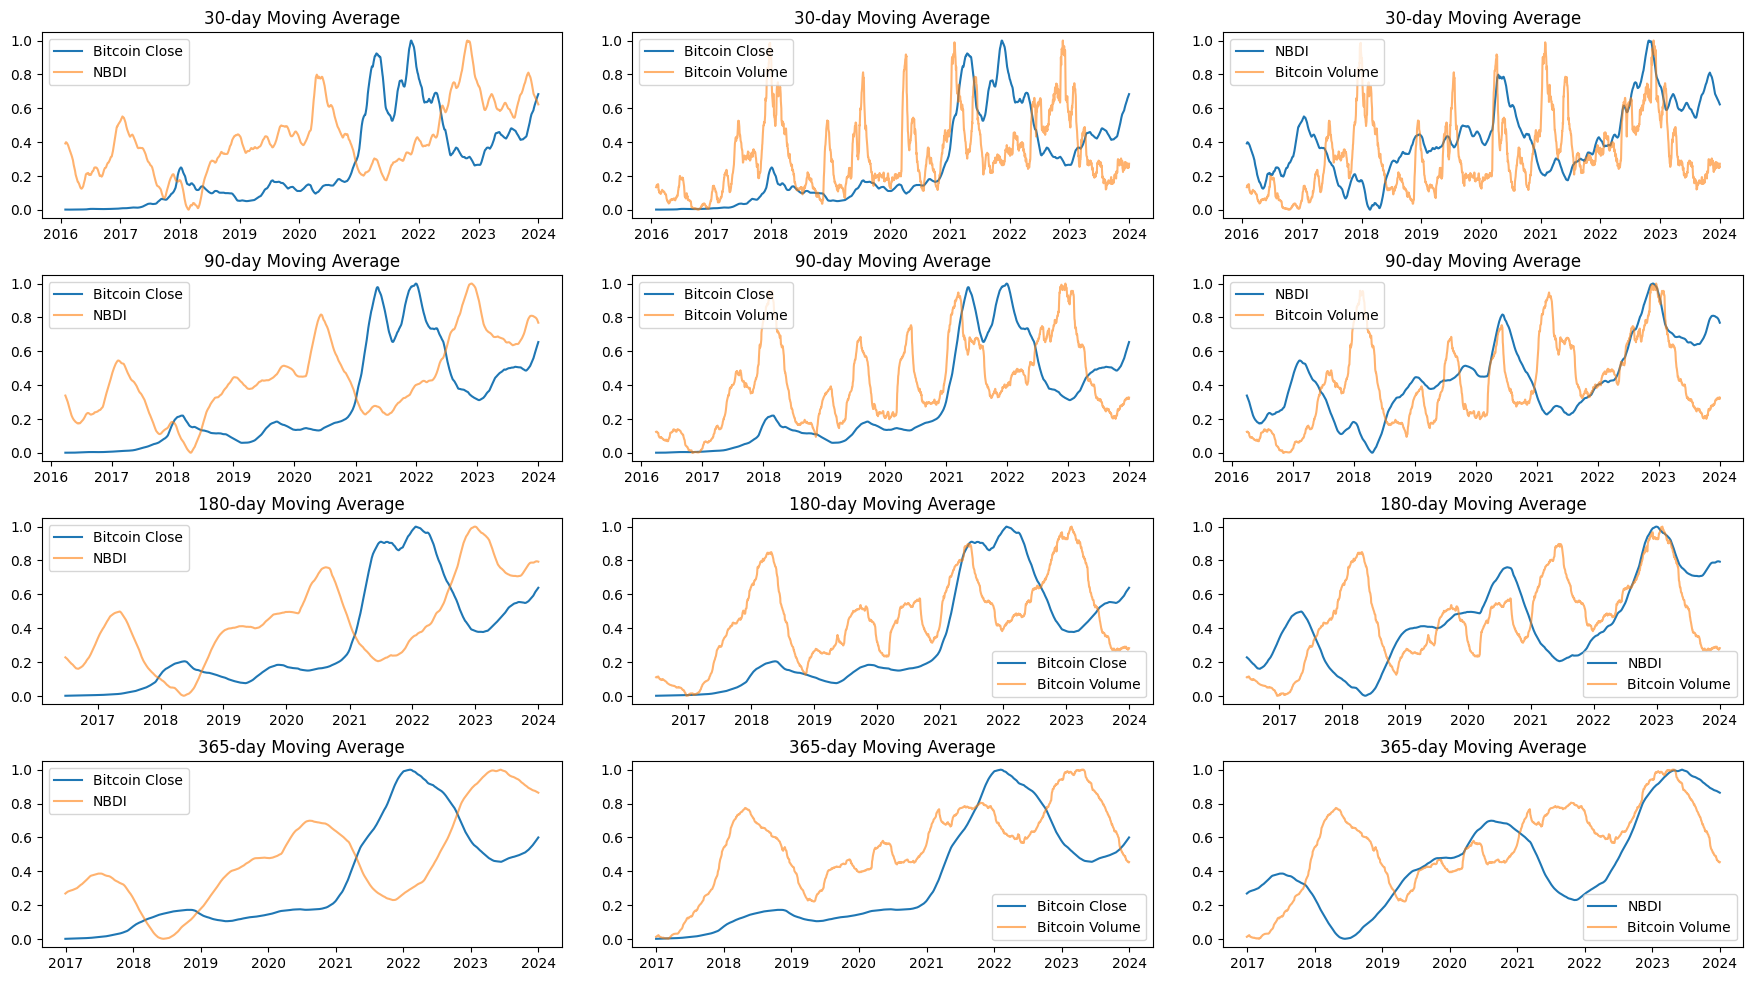

In [15]:
# visually inspect with smoothing
ma = [30, 90, 180, 365]
n_ma = len(ma)
fig, ax = plt.subplots(n_ma, 3, layout='constrained', figsize=(18, 10))
fig.tight_layout(pad=2)
for row, m in enumerate(ma):
    fields = {
        'Bitcoin Close': MinMaxScaler().fit_transform(df.close.rolling(m).mean().values.reshape(-1, 1)),
        'NBDI': MinMaxScaler().fit_transform(df.nbdi.rolling(m).mean().values.reshape(-1, 1)),
        'Bitcoin Volume': MinMaxScaler().fit_transform(df.volume.rolling(m).mean().values.reshape(-1, 1))
    }
    c = 0
    for col1, col2 in combinations(fields.keys(), 2):
        ax[row][c].plot(df.index, fields.get(col1), label=col1)
        ax[row][c].plot(df.index, fields.get(col2), label=col2, alpha=0.6)
        ax[row][c].legend()
        ax[row][c].title.set_text(f'{m}-day Moving Average')
        c += 1
plt.show()

#### Findings

- Possible lag effect is more pronounced between NBDI and close price.
- No apparent relationship between volume and close price.
- No apparent relationship between NBDI and volume

<hr>

## Price Autocorrelation

ADF: 0.000000000000000
KPSS: (0.035025216434009555, 0.1, 137, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


/tmp/ipykernel_188766/1340410687.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  print(f'KPSS: {kpss(df.close_diff.dropna())}')


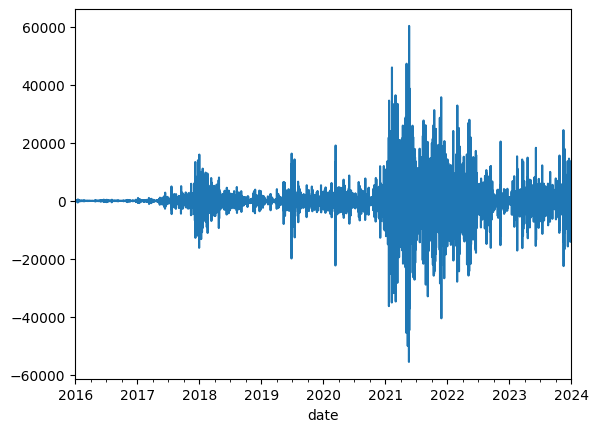

In [153]:
# make price stationary for ACF/PACF
df.close_diff.plot()

print(f'ADF: {adfuller(df.close_diff.dropna())[1]:.15f}')
print(f'KPSS: {kpss(df.close_diff.dropna())}')

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

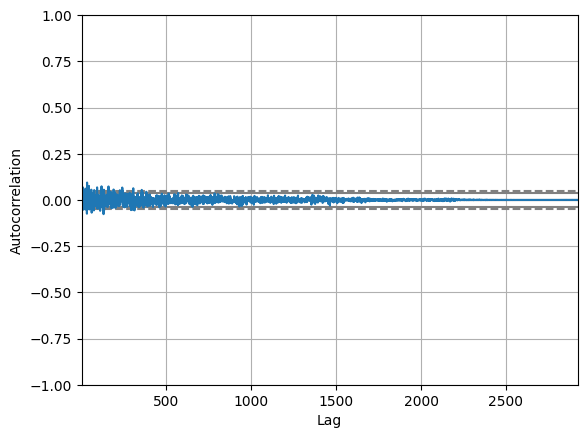

In [165]:
pd.plotting.autocorrelation_plot(df.close_diff.dropna())

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

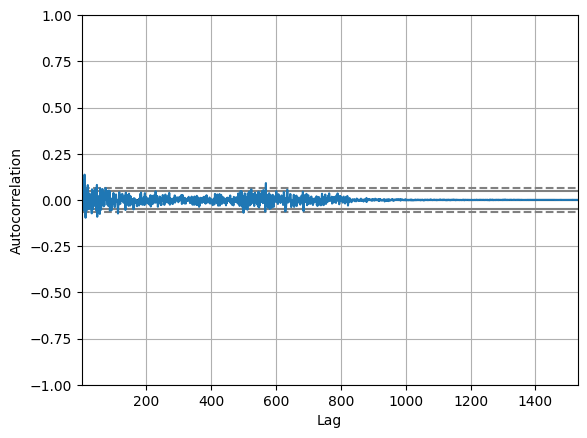

In [166]:
pd.plotting.autocorrelation_plot(pre_pandemic.close_diff.dropna())

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

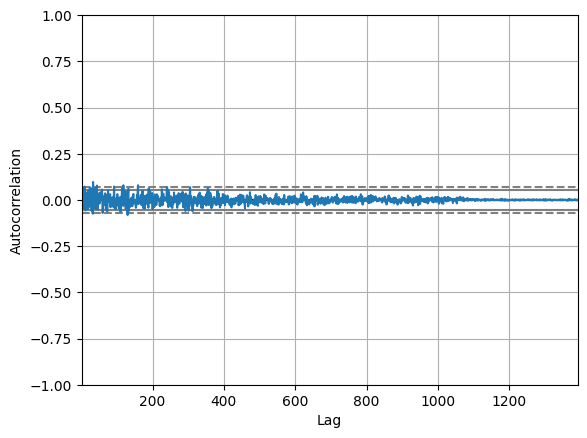

In [167]:
pd.plotting.autocorrelation_plot(post_pandemic.close_diff.dropna())

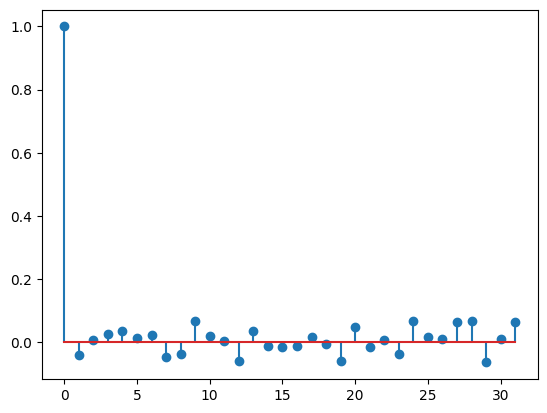

In [168]:
# partial autocorrelation
auto = pacf(post_pandemic.close_diff.dropna().values)
plt.stem(auto)
plt.show()

#### Findings

- No autocorrelation found when price is made stationary.  Deriving featurs from close price based on EDA would be unreliable.  Advisable to use features based on domain knowledge - immediate lag values and moving averages.

### Cross-correlation - NBDI over Close Price

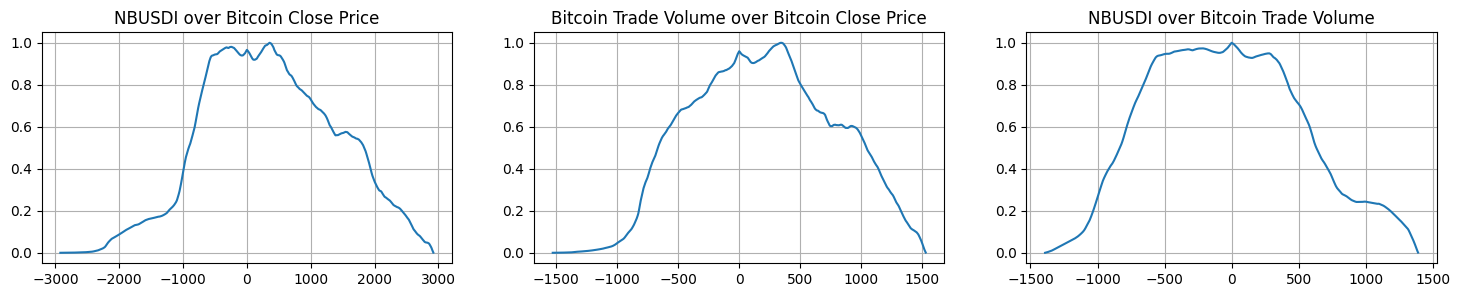

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(18, 3))

corr = correlate(close_mmscaled, nbdi_mmscaled)
corr /= np.max(corr)
lags = correlation_lags(len(df.nbdi.values), len(df.close.values))
ax[0].plot(lags, corr)
ax[0].grid(which='both', axis='both')
ax[0].title.set_text("NBUSDI over Bitcoin Close Price")

corr = correlate(close_scaler.transform(pre_pandemic.close.values.reshape(-1, 1)), nbdi_scaler.transform(pre_pandemic.nbdi.values.reshape(-1, 1)))
corr /= np.max(corr)
lags = correlation_lags(len(pre_pandemic.nbdi.values), len(pre_pandemic.close.values))
ax[1].plot(lags, corr)
ax[1].grid(which='both', axis='both')
ax[1].title.set_text("Bitcoin Trade Volume over Bitcoin Close Price")

corr = correlate(close_scaler.transform(post_pandemic.close.values.reshape(-1, 1)), nbdi_scaler.transform(post_pandemic.nbdi.values.reshape(-1, 1)))
corr /= np.max(corr)
lags = correlation_lags(len(post_pandemic.nbdi.values), len(post_pandemic.close.values))
ax[2].plot(lags, corr)
ax[2].grid(which='both', axis='both')
ax[2].title.set_text("NBUSDI over Bitcoin Trade Volume")

plt.show()

#### Findings

- Overall, NBDI values appear to lag price around one year.  Pre-pandemic has a high lag correlation up to one year, and post-pandemic has an earlier and relatively lower correlation.  Lag correlation decays fairly quickly after this point.
- Price may lead NBDI, and the affect grows into the post-pandemic segment.
- Lead and lag effects corroborate undulating patterns between price and nbdi has seen in moving averages above.

## Granger Causality

In [227]:
df = pd.DataFrame({'close_scaled': close_mmscaled.ravel(), 'volume_scaled': volume_mmscaled.ravel(), 'nbdi_scaled': nbdi_mmscaled.ravel()})

In [228]:
def do_granger(df, x1, x2, lags, siglevel=0.05):
    gct = grangercausalitytests(df[[x1, x2]], lags, verbose=False)
    significant = []
    for i, result in gct.items():
        for test, scores in result[0].items():
            if scores[1] <= siglevel:
                significant.append((i, test, scores[1]))
    if len(significant) == 0:
        print('No significant results for {x1}, {x2}')
    else:
        print(f'{x1}, {x2}')
        for s in significant:
            print(f'Lag {s[0]}: {s[1]} with p-value {s[2]:.6f}')

lags = [1, 7, 14, 30, 90, 180, 365]
siglevel = 0.01

do_granger(df, 'close_scaled', 'nbdi_scaled', lags, siglevel)
do_granger(df, 'close_scaled', 'volume_scaled', lags, siglevel)

/home/roy/capstone/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


close_scaled, nbdi_scaled
Lag 365: ssr_chi2test with p-value 0.000024
Lag 365: lrtest with p-value 0.002749


/home/roy/capstone/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


close_scaled, volume_scaled
Lag 365: ssr_ftest with p-value 0.008026
Lag 365: ssr_chi2test with p-value 0.000000
Lag 365: lrtest with p-value 0.000000
Lag 365: params_ftest with p-value 0.008026


### Findings

A one year lag for both nbdi value and trade volume show causal relationships at <0.01 p-value.